# Test de la sauvegarde-reprise

In [1]:
import sys
import os

lib_path = os.path.realpath(os.path.join(os.getcwd(), ".."))
if lib_path not in sys.path:
    sys.path = [lib_path] + sys.path
savefig_path = os.path.join(lib_path, "figures/")
save_fig = True

In [2]:
from src.main_discontinu import *
from src.plot_fields import *
from src.time_problem import *
from src.plot_stats import *

%matplotlib widget
rc("figure", figsize=(10, 5))
rc("figure", dpi=100)
rc("font", size=18)
rc("legend", fontsize=16)
rc("text.latex", preamble=r"\usepackage{siunitx}")

## Test avec la formulation TOF

Ici on va réaliser une simulation jusqu'à $t_0$, la sauvegarder et la reprendre pendant à nouveau un temps $t_0$, et comparer les réslutats avec ceux obtenus en lançant d'une traite la même simulation pendant $2 t_0$.

La résolution se fait à chaque fois en Quick avec Euler explicite en temps.

In [3]:
n_lim = 10**8
t_0 = 0.02

In [4]:
# d = 6./100*Delta/2.
dx = 0.06 / 30.0
phy_prop_conv = PhysicalProperties(
    Delta=1.0,
    v=1.0,
    dS=0.005**2,
    lda1=1.0,
    lda2=1.0,
    rho_cp1=1.0,
    rho_cp2=1.0,
    diff=1.0,
    alpha=0.06,
    a_i=357.0,
)
num_prop_quick = NumericalProperties(
    dx=dx,
    schema="quick",
    time_scheme="euler",
    phy_prop=phy_prop_conv,
    cfl=0.3,
    fo=0.3,
)
markers = Bulles(phy_prop=phy_prop_conv, n_bulle=1)


TOF
===
dt fourier
1.2e-06
Db / dx = 30
Monofluid convection :  quick

TOF
===
dt fourier
1.2e-06
Db / dx = 30
Monofluid convection :  quick
Liste des simus similaires : 
['../References/TOF, euler, quick, dx = 0.002, dt = 1.2e-06, cfl = 0.0006_t_0.019999.pkl']
Loading ======> ../References/TOF, euler, quick, dx = 0.002, dt = 1.2e-06, cfl = 0.0006_t_0.019999.pkl
remaining time to compute : 0.000001
Liste des simus similaires : 
['../References/statistics_TOF, euler, quick, dx = 0.002, dt = 1.2e-06, cfl = 0.0006_t_0.019999.pkl']

TOF
===
dt fourier
1.2e-06
Db / dx = 30
Monofluid convection :  quick


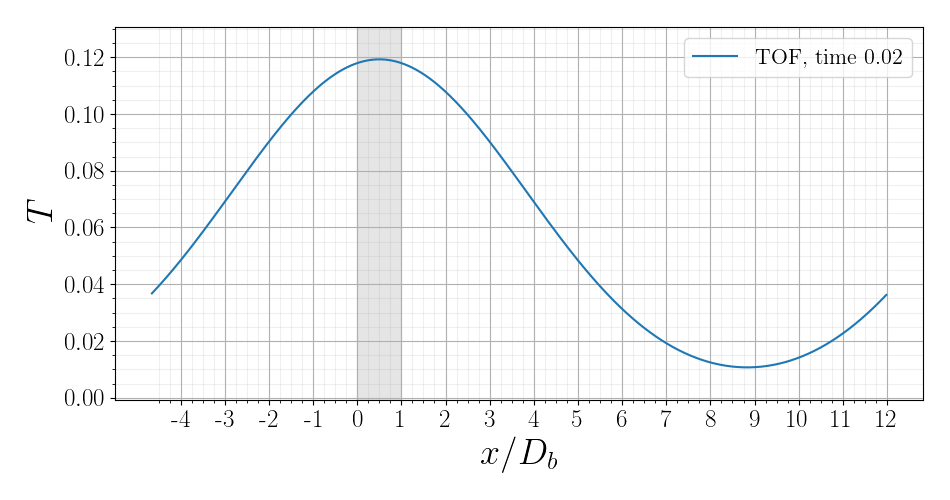

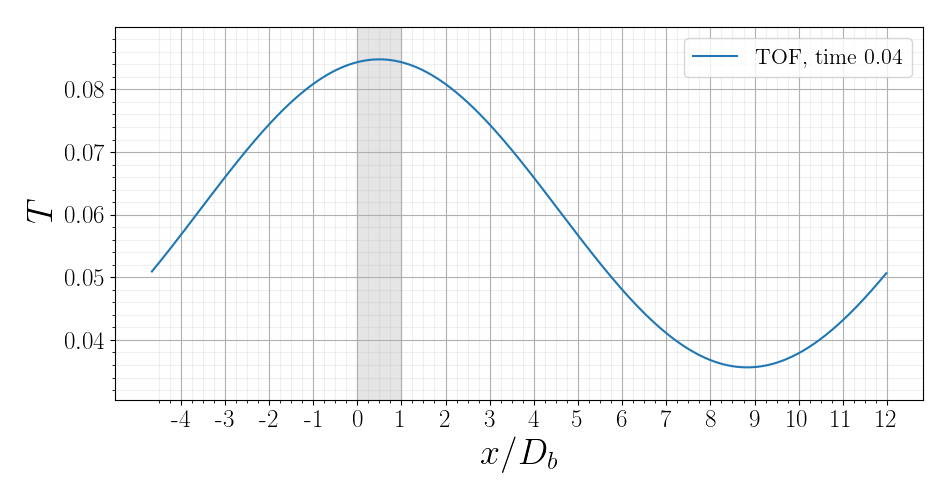

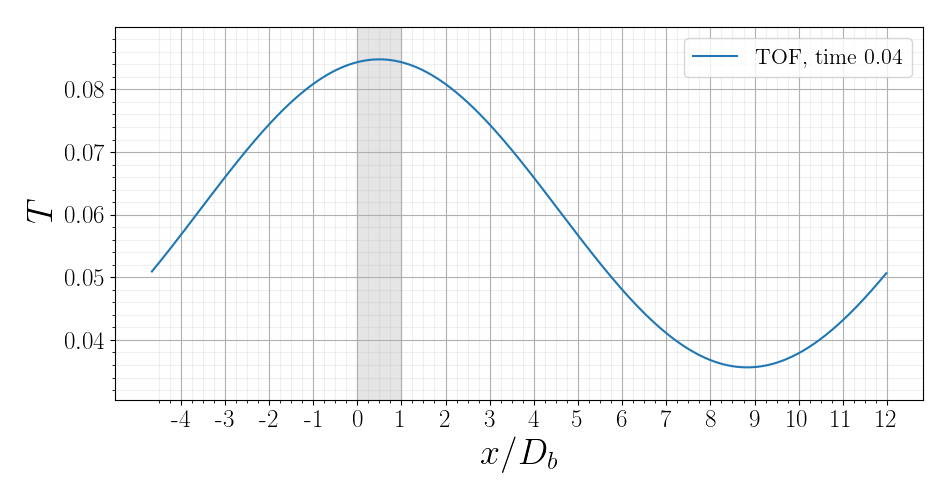

In [5]:
prob_quick_debut = TimeProblem(
    get_T_creneau, markers=markers, phy_prop=phy_prop_conv, num_prop=num_prop_quick
)
t, e = prob_quick_debut.timestep(
    t_fin=t_0,
    n=n_lim,
    number_of_plots=1,
    plotter=Plotter("decale", ispretty=True),
)
prob_quick_debut.save()

prob_quick_fin = TimeProblem(
    get_T_creneau, markers=markers, phy_prop=phy_prop_conv, num_prop=num_prop_quick
)
prob_quick_fin.load(t_fin=t_0)
t, e = prob_quick_fin.timestep(
    t_fin=2 * t_0 - prob_quick_fin.problem_state.time,
    n=n_lim,
    number_of_plots=1,
    plotter=Plotter("decale", ispretty=True),
)

prob_quick_total = TimeProblem(
    get_T_creneau, markers=markers, phy_prop=phy_prop_conv, num_prop=num_prop_quick
)
t, e = prob_quick_total.timestep(
    t_fin=2 * t_0,
    n=n_lim,
    number_of_plots=1,
    plotter=Plotter("decale", ispretty=True),
)

'#ff7f0e'

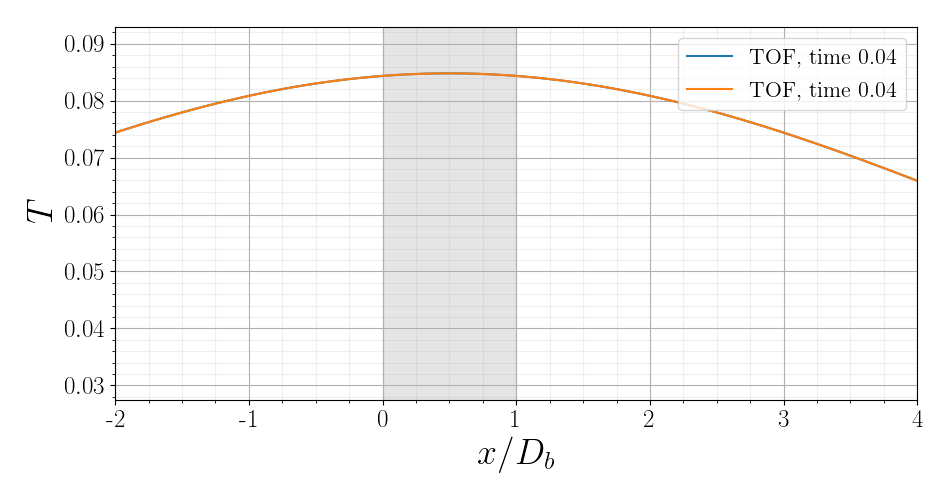

In [6]:
plot = Plotter("decale", ispretty=True, zoom=(-2, 4))
plot.plot(prob_quick_fin.problem_state)
plot.plot(prob_quick_total.problem_state)

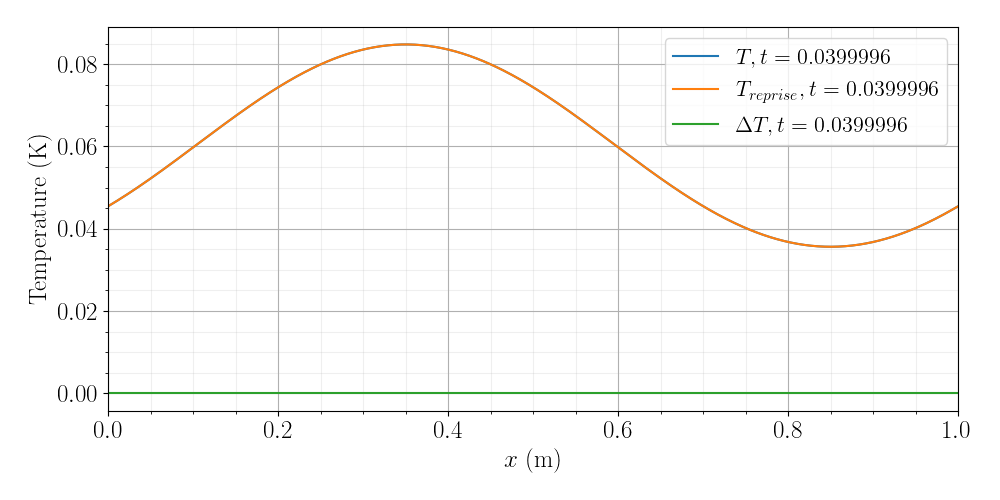

In [7]:
fig, ax = plt.subplots()
pbtot = prob_quick_total.problem_state
pbfin = prob_quick_fin.problem_state
ax.plot(pbtot.x, pbtot.T, label=r"$T, t = %g$" % pbtot.time)
ax.plot(pbtot.x, pbfin.T, label=r"$T_{reprise}, t = %g$" % pbtot.time)
ax.plot(pbtot.x, pbtot.T - pbfin.T, label=r"$\Delta T, t = %g$" % pbtot.time)
ax.legend()
ax.minorticks_on()
ax.grid(visible=True, which="major")
ax.grid(visible=True, which="minor", alpha=0.2)
ax.set_xlim(0.0, 1.0)
ax.set_xlabel(r"$x$ (m)")
ax.set_ylabel(r"Temperature (K)")
fig.tight_layout()
fig.savefig(os.path.join(os.getcwd(), "../figures/", "sauvegarde_reprise/deltaT.pdf"))


$T_l$, TOF
dT/dt = 0.201699

$T_v$, TOF
dT/dt = -3.15995

$T_l$, TOF
dT/dt = 0.201699

$T_v$, TOF
dT/dt = -3.15995


(0.0, 1.0)

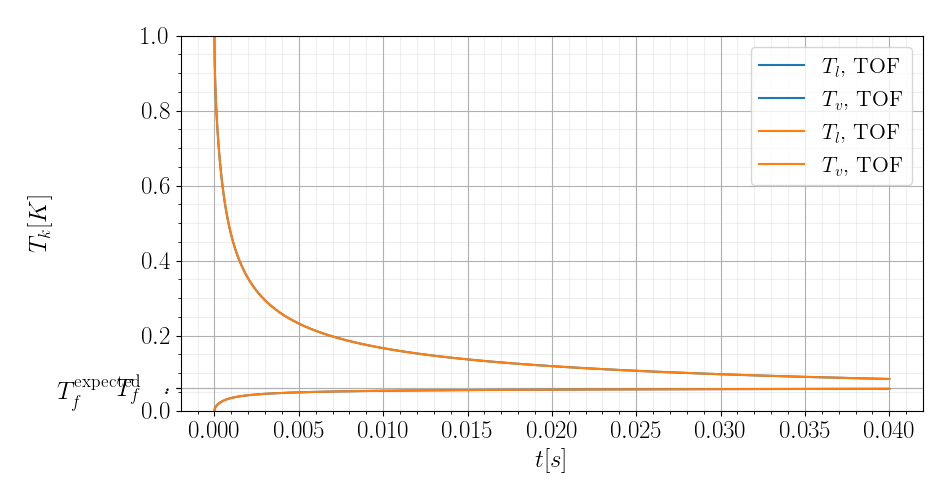

In [8]:
plot_T = TemperaturePlot()
plot_T.plot_tpb(prob_quick_fin)
plot_T.plot_tpb(prob_quick_total)
plot_T.add_T_final()
plot_T.ax.set_ylim(0, 1)

In [9]:
def plot_dTdt(stat, plot, **args):
    dTdt = np.gradient(stat.Tv, stat.t)
    plot.ax.plot(stat.t, dTdt, **args)

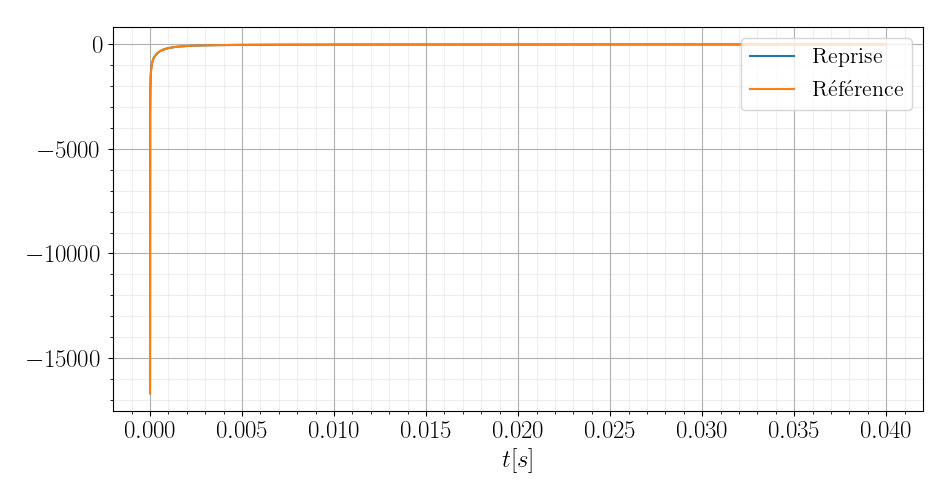

In [10]:
plot_dT = TimePlot()
plot_dTdt(prob_quick_fin.stat, plot_dT, label="Reprise")
plot_dTdt(prob_quick_total.stat, plot_dT, label="Référence")
le = plot_dT.ax.legend()
plot_dT.fig.tight_layout()

In [11]:
def compute_nu(stat, phy_prop):
    dTdt = np.gradient(stat.Tl, stat.t)
    DeltaT = stat.Tv - stat.Tl
    nu = (
        phy_prop.rho_cp1
        * dTdt
        * phy_prop.Delta
        * phy_prop.alpha
        / (2.0 * phy_prop.lda1 * DeltaT)
    )
    return nu

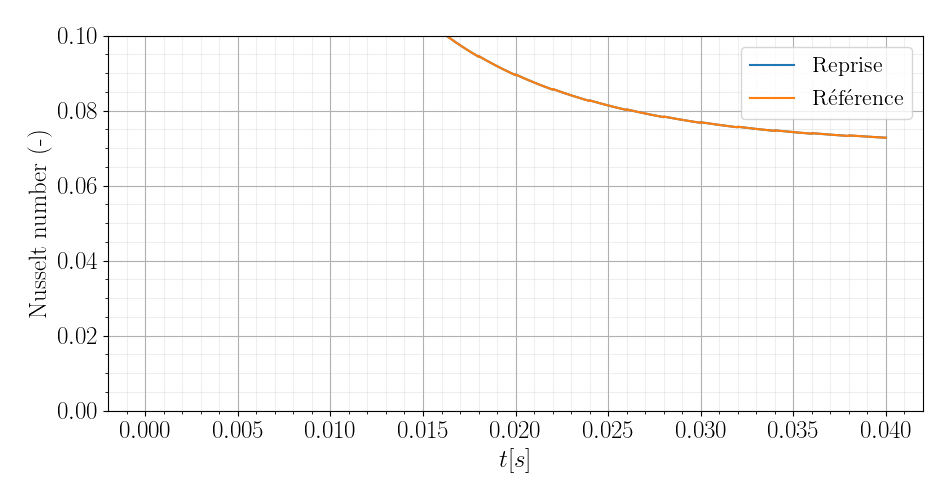

In [12]:
plot_Nu = TimePlot()
plot_Nu.ax.plot(
    prob_quick_fin.stat.t,
    compute_nu(prob_quick_fin.stat, phy_prop_conv),
    label=r"Reprise",
)
plot_Nu.ax.plot(
    prob_quick_total.stat.t,
    compute_nu(prob_quick_total.stat, phy_prop_conv),
    label=r"Référence",
)
plot_Nu.ax.legend()
plot_Nu.ax.set_ylim(0.0, 0.1)
plot_Nu.ax.set_ylabel(r"Nusselt number (-)")
plot_Nu.fig.tight_layout()